## Dependencies

In [1]:
!pip3 show torch

Name: torch
Version: 1.4.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages
Requires: 
Required-by: torchvision, fastai


In [ ]:
!git clone https://github.com/bfortuner/pytorch_tiramisu/

In [ ]:
!mv pytorch_tiramisu/* .

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from models import tiramisu
from datasets import camvid
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils

## CamVid

Clone this repository which holds the CamVid dataset
```
git clone https://github.com/alexgkendall/SegNet-Tutorial
```

In [ ]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial

In [3]:
CAMVID_PATH = Path('', 'SegNet-Tutorial/CamVid')
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
batch_size = 2

In [4]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)
train_joint_transformer = transforms.Compose([
    #joint_transforms.JointRandomCrop(224), # commented for fine-tuning
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

Train: 367
Val: 101
Test: 233
Classes: 12
Inputs:  torch.Size([2, 3, 360, 480])
Targets:  torch.Size([2, 360, 480])


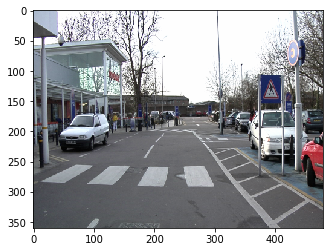

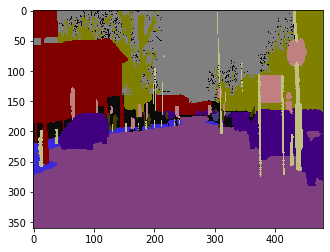

In [5]:
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
print("Classes: %d" % len(train_loader.dataset.classes))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

utils.imgs.view_image(inputs[0])
utils.imgs.view_annotated(targets[0])

## Train

In [6]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 20
torch.cuda.manual_seed(0)

In [7]:
model = tiramisu.FCDenseNet67(n_classes=12).cuda()
model.apply(train_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss(weight=camvid.class_weight.cuda()).cuda()

In [8]:
N_EPOCHS = 2

In [ ]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()
    torch.cuda.empty_cache()

    ### Train ###
    trn_loss, trn_err = train_utils.train(
        model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))


    val_loss = 0.1
    val_err = 0.1
    ### Test ###
    val_loss, val_err = train_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    train_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Epoch 1
Train - Loss: 0.8601, Acc: 1.0000
Train Time 5m 18s
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
Val - Loss: 0.8807 | Acc: 1.0000
Total Time 5m 47s

Epoch 2
Train - Loss: 0.7970, Acc: 1.0000
Train Time 4m 32s
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
Val - Loss: 0.8172 | Acc: 1.0000
Total Time 4m 57s

Epoch 3
Train - Loss: 0.7659, Acc: 1.0000
Train Time 4m 32s
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
Val - Loss: 0.9234 | Acc: 1.0000
Total Time 4m 58s

Epoch 4
Train - Loss: 0.7590, Acc: 1.0000
Train Time 4m 34s
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
Val - Loss: 0.8690 | Acc: 1.0000
Total Time 5m 2s

Epoch 5
Train - Loss: 0.7462, Acc: 1.0000
Train Time 4m 34s
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2

## Test

In [9]:
torch.cuda.empty_cache()
import os
weights_fname = 'weights-%d-%.3f-%.3f.pth' % (11, 0.690, 0.000)
weights_fpath = os.path.join(WEIGHTS_PATH, weights_fname)

# path = ".weights/weights-11-0.690-0.000.pth"

# model = model.cpu()
# criterion =  criterion.cpu()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

train_utils.load_weights(model,weights_fpath)

# train_utils.test(model, test_loader, criterion, epoch=1)  

loading weights '.weights/weights-11-0.690-0.000.pth'
loaded weights (lastEpoch 10, loss 0.6897057890892029, error 0.0)


11

In [19]:
train_utils.test(model, test_loader, criterion, epoch=1)  

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1


(tensor(0.9335, device='cuda:0'), tensor(0., dtype=torch.float64))

2


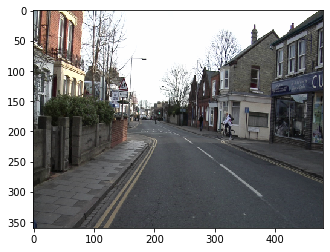

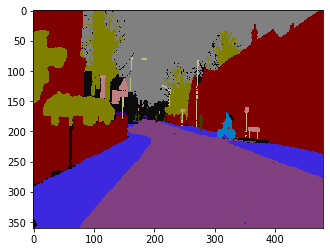

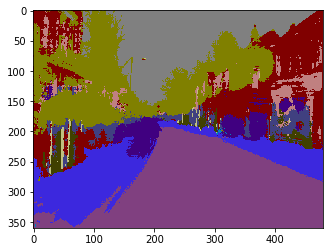

In [10]:
train_utils.view_sample_predictions(model, test_loader, n=1)